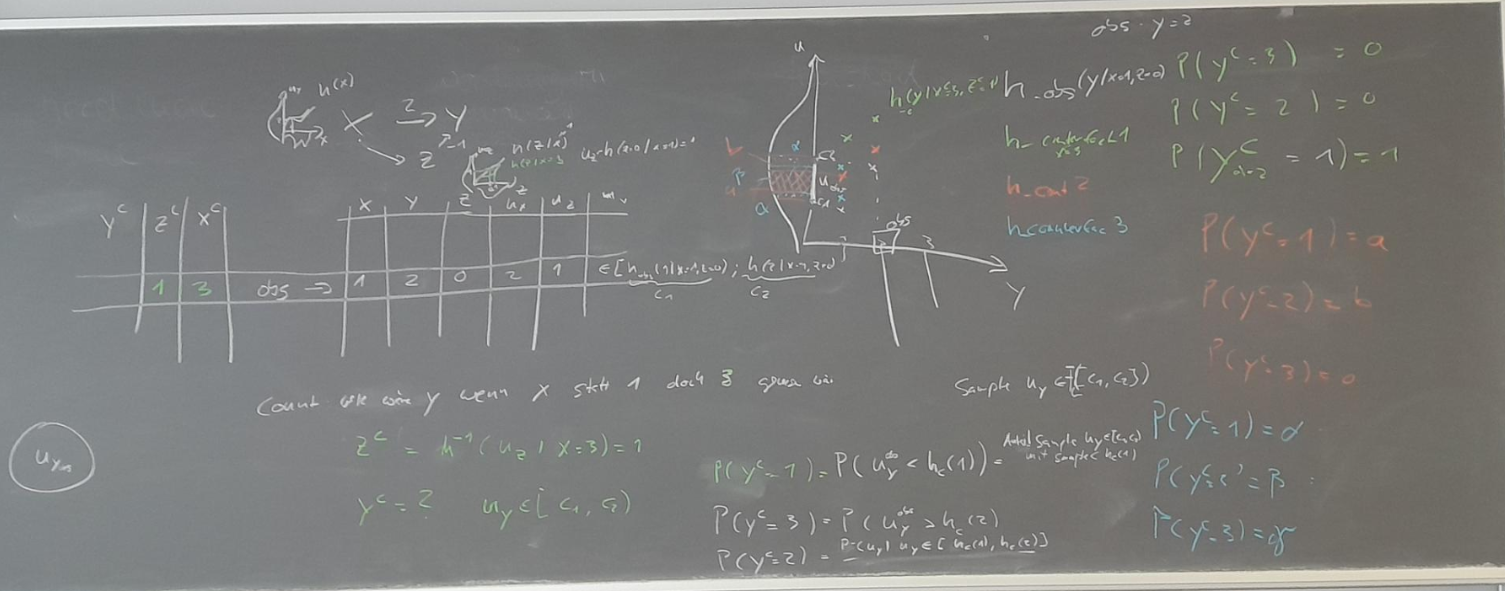

# Reproducing experiment 6.2 from Tramdag paper

In [1]:
import os
# from tramdag.utils.configuration import *

from tramdag import TramDagConfig
from sklearn.model_selection import train_test_split

In [2]:
experiment_name = "plot_ordinal_trafo_fkt"      ## <--- set experiment name
LOG_DIR="/home/bule/TramDag/dev_experiment_logs"  ## <--- set log directory
EXPERIMENT_DIR = os.path.join(LOG_DIR, experiment_name)
CONF_DICT_PATH = os.path.join(EXPERIMENT_DIR, f"configuration.json")
cfg=TramDagConfig()
cfg.setup_configuration(experiment_name,EXPERIMENT_DIR)

Configuration already exists: /home/bule/TramDag/dev_experiment_logs/plot_ordinal_trafo_fkt/configuration.json


Setting seed: 42
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   x1      100000 non-null  float64
 1   x2      100000 non-null  float64
 2   x3      100000 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 2.3 MB
Train size: 80000, Validation size: 10000, Test size: 10000


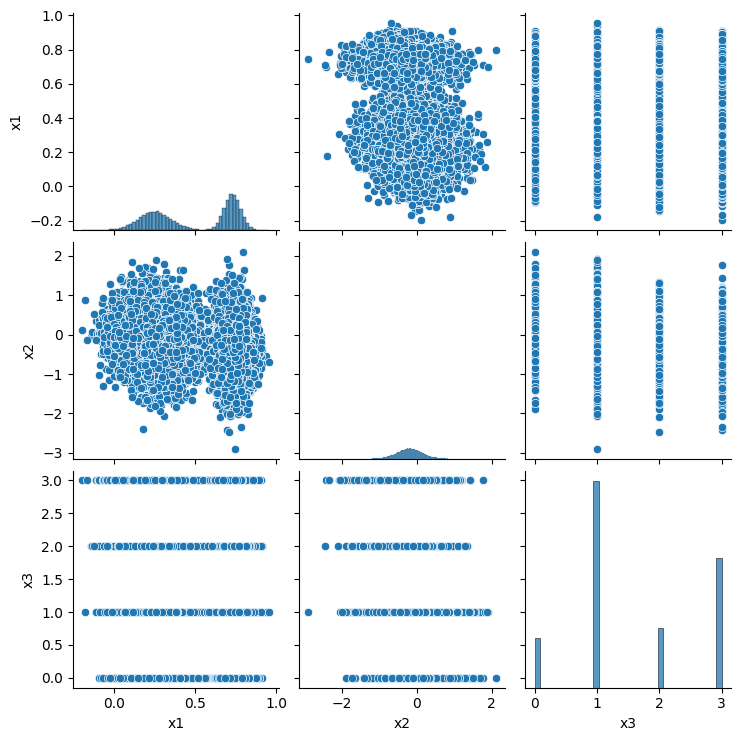

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns

def dgp(n_obs, doX=[None, None, None], f=lambda x: x, seed=None):
    """
    Data-generating process matching the provided R implementation.
    
    Parameters
    ----------
    n_obs : int
        Number of observations to generate.
    doX : list of length 3
        If doX[i] is not None, fixes X_{i+1} to that constant for all draws.
    f : callable
        A function of X2 used in generating X3 (defaults to identity).
    seed : int or None
        If provided, sets the NumPy random seed.
    
    Returns
    -------
    pd.DataFrame
        DataFrame with columns ['x1', 'x2', 'x3'], where x3 is an ordered
        categorical with levels 1 < 2 < 3 < 4.
    """
    if seed is not None:
        np.random.seed(seed)
        print(f"Setting seed: {seed}")

    # --- 1. Sample X1 from a 2-component GMM ---
    if doX[0] is None:
        X1_A = np.random.normal(loc=0.25, scale=0.10, size=n_obs)
        X1_B = np.random.normal(loc=0.73, scale=0.05, size=n_obs)
        mix = np.random.choice([0, 1], size=n_obs)
        x1 = np.where(mix == 0, X1_A, X1_B)
    else:
        x1 = np.full(n_obs, doX[0], dtype=float)

    # --- 2. Sample X2 via shifted-logit inversion (as in R) ---
    if doX[1] is None:
        # draw U2 ~ Uniform(0,1) and map through quantile of logistic
        u2 = np.random.uniform(size=n_obs)
        z2 = np.log(u2 / (1 - u2))  # qlogis
        # replicate: X2 = (z2 - 2 * x1) / 5
        x2 = (z2 - 2 * x1) / 5.0
    else:
        x2 = np.full(n_obs, doX[1], dtype=float)

    # --- 3. Sample X3 as an ordinal via logistic thresholds ---
    if doX[2] is None:
        # latent U3 ~ Logistic(0,1)
        u3 = np.random.logistic(loc=0.0, scale=1.0, size=n_obs)
        # thresholds theta_k = (-2, 0.42, 1.02)
        theta = np.array([-2.0, 0.42, 1.02])
        # compute h[i,k] = theta_k + 0.2 * x1[i] + f(x2[i])
        h = theta + 0.2 * x1.reshape(-1, 1) + f(x2).reshape(-1, 1)
        # assign x3 starting at 0
        x3 = np.zeros(n_obs, dtype=int)
        x3[u3 > h[:, 0]] = 1
        x3[u3 > h[:, 1]] = 2
        x3[u3 > h[:, 2]] = 3
        # convert to ordered categorical
        x3 = pd.Categorical(x3, categories=[0, 1, 2, 3], ordered=True)
    else:
        x3 = pd.Categorical(
            np.full(n_obs, doX[2], dtype=int),
            categories=[0, 1, 2, 3],
            ordered=True
        )
        
    # x3 = x3.astype(float) / 4.0
    x3 = x3.astype(int) 
    return pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3})

df = dgp(n_obs=100_000, seed=42)
df.info()
sns.pairplot(df)

train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")


In [4]:
data_type= {'x1':'continous','x2':'continous','x3':'ordinal_Xn_Yo'} 
cfg.set_data_type(data_type)

---------------------------------------------------------------------------------------------------------
                                       |                       MODEL SETTINGS                       
Variable             | dtype           | As Predictor                   | As Target                     
---------------------------------------------------------------------------------------------------------
x1                   | continous       | continuous [c]                 | continuous [c]                
x2                   | continous       | continuous [c]                 | continuous [c]                
x3                   | ordinal_Xn_Yo   | ordinal [0,…,K]                | ordinal    [0,…,K]            
---------------------------------------------------------------------------------------------------------
Configuration updated successfully at /home/bule/TramDag/dev_experiment_logs/plot_ordinal_trafo_fkt/configuration.json.


/home/bule/TramDag/tramdag/utils/configuration.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


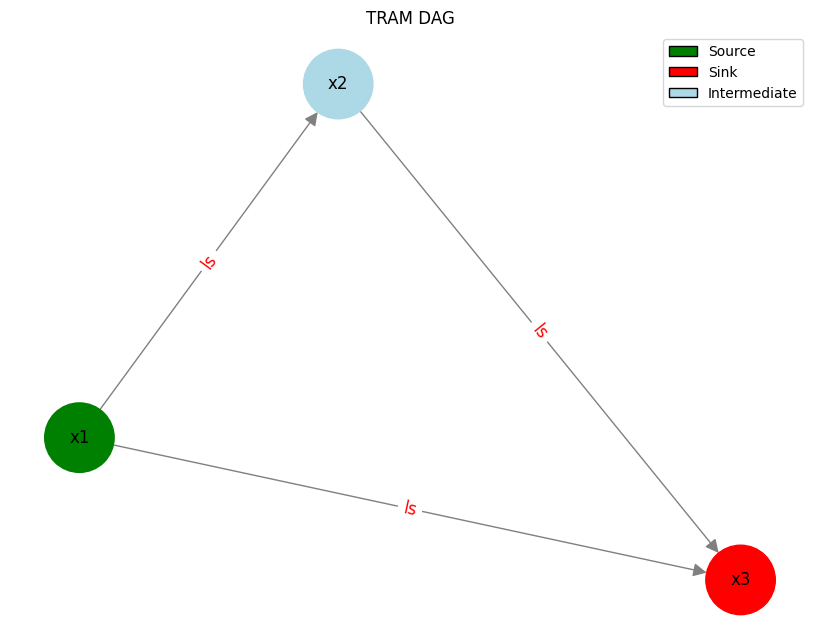

In [5]:
cfg.set_meta_adj_matrix()



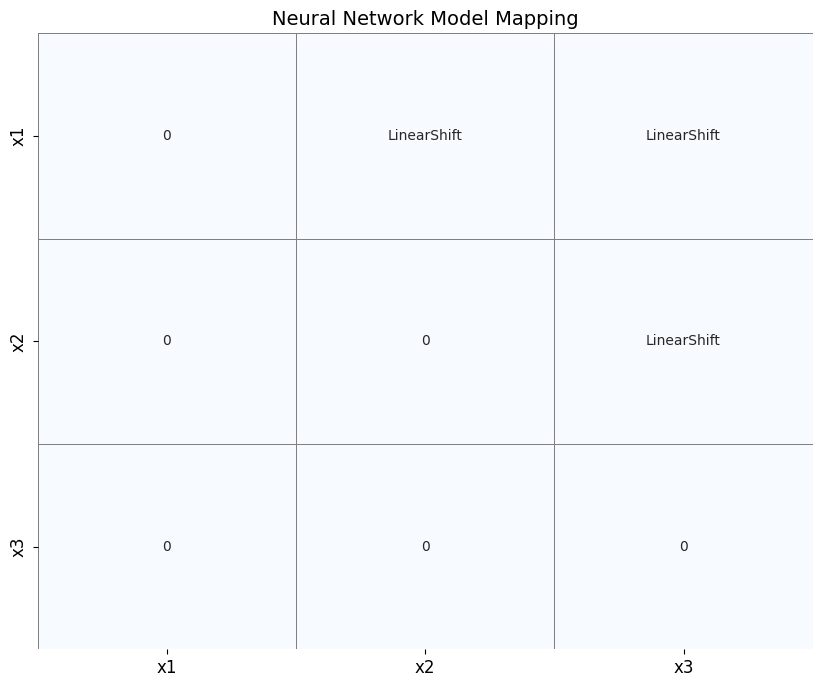

In [6]:
cfg.set_tramdag_nn_models()

# Model training & sampling

In [7]:
from tramdag import TramDagModel

cfg.compute_levels(train_df)
device='cpu'

In [8]:
td_model = TramDagModel.from_config(cfg, set_initial_weights=False,verbose=True,debug=False,device=device,initial_data = train_df) 


In [9]:
td_model.fit(train_df, val_df,
            #  train_list=['target'],
             learning_rate=1e-2,
             epochs=200,batch_size=1000,
             verbose=True,debug=False,
             device=device,
             num_workers = 8,
             persistent_workers = True,
             prefetch_factor = 8,
             train_mode = "sequential")#,

[INFO] Computing new minmax dict from training data...
[INFO] Saved new minmax dict to /home/bule/TramDag/dev_experiment_logs/plot_ordinal_trafo_fkt/min_max_scaling.json
[INFO] Training 3 nodes (sequential) on cpu

[INFO] Training node 'x1' for 200 epochs on cpu (pid=2858033)
[INFO] Existing model found. Loading weights and history from LAST model...

[INFO] Training node 'x2' for 200 epochs on cpu (pid=2858033)
[INFO] Existing model found. Loading weights and history from LAST model...

[INFO] Training node 'x3' for 200 epochs on cpu (pid=2858033)
[INFO] Existing model found. Loading weights and history from LAST model...


[INFO] Loaded training/validation histories for 3 nodes.


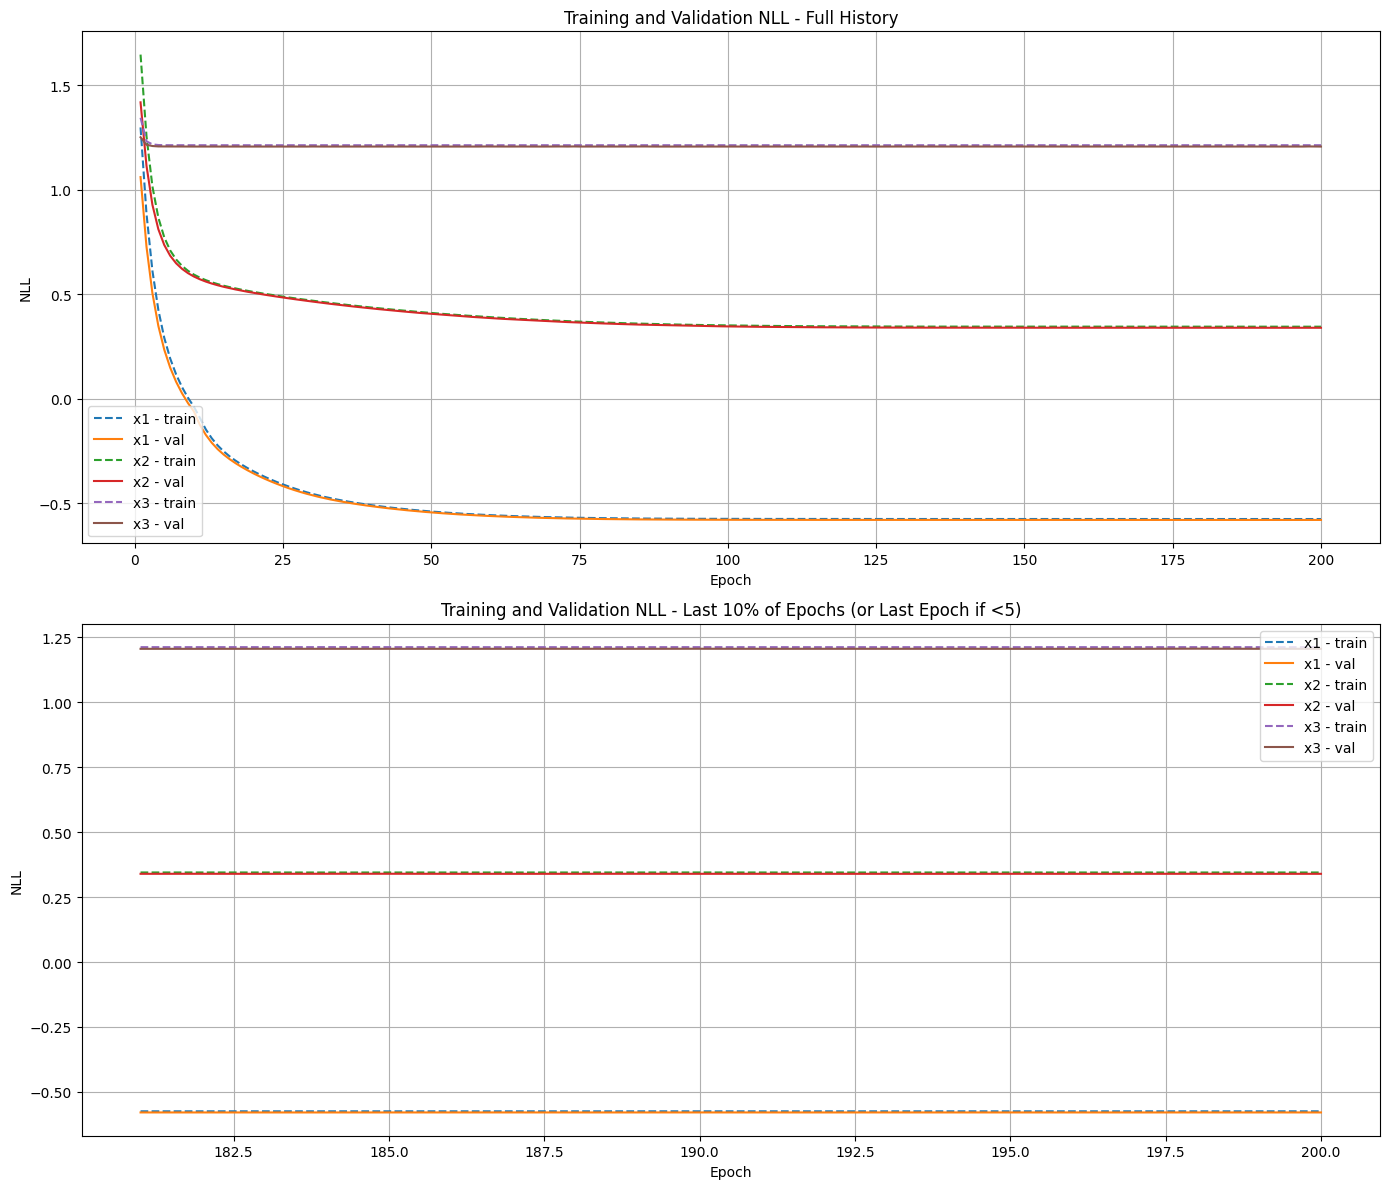

In [10]:
td_model.plot_loss_history()

```
  Continuous Outcome Logistic Regression 

Call:
Colr(formula = x2 ~ x1, data = data_6_2)

Coefficients:
      x1 
1.973891 

Log-Likelihood:
 -31293.99 (df = 8)
```
---------------------------------------------------
```
# > polr(x3_factor ~ x1 + x2, data = data_6_2)
# Call:
# polr(formula = x3_factor ~ x1 + x2, data = data_6_2)

# Coefficients:
#         x1         x2 
# -0.1815344 -1.0012274 
```

In [11]:
# td_model.plot_linear_shift_history(ref_lines={'x2':[1.973827],'x3':[-0.1815344, -1.0012274 ]}) 

```
# > polr(x3_factor ~ x1 + x2, data = data_6_2)
# Call:
# polr(formula = x3_factor ~ x1 + x2, data = data_6_2)

# Coefficients:
#         x1         x2 
# -0.1815344 -1.0012274 

# Intercepts:
#       0|1       1|2       2|3 
# -1.998953  0.426397  1.032376 

# Residual Deviance: 194022.51 
# AIC: 194032.51 
```

avg NLL
194022.51 /( 2 *80_000) =  1.2126406875


In [12]:
# # [-2.054361   0.3095475  0.897935 ]

# td_model.plot_simple_intercepts_history(ref_lines={'x3':[-1.998953,  0.426397,  1.032376]})

In [13]:
# td_model.plot_hdag(train_df,variables=['x1','x2','x3'],plot_n_rows=1)

In [14]:
# def compute_ordinal_nll_and_confusion_from_file(pred_csv_path):
#     import numpy as np
#     import pandas as pd
#     from sklearn.metrics import confusion_matrix

#     preds = pd.read_csv(pred_csv_path)

#     def parse_list(x):
#         if isinstance(x, str):
#             return np.array(eval(x))
#         return np.array(x)

#     nlls = []
#     true_classes = []
#     pred_classes = []

#     for _, row in preds.iterrows():
#         probs = parse_list(row["probs"])
#         y = int(row["x3"])
#         p = probs[y] if y < len(probs) else 1e-9
#         nlls.append(-np.log(p + 1e-9))
#         true_classes.append(y)
#         pred_classes.append(int(np.argmax(probs)))

#     preds["true_class"] = true_classes
#     preds["pred_class"] = pred_classes
#     preds["nll"] = nlls

#     mean_nll = float(np.mean(nlls))
#     cm = confusion_matrix(true_classes, pred_classes)

#     out_path = pred_csv_path.replace(".csv", "_with_nll.csv")
#     preds.to_csv(out_path, index=False)

#     cm_path = pred_csv_path.replace(".csv", "_confusion_matrix.csv")
#     pd.DataFrame(cm).to_csv(cm_path, index=False)

#     print(f"Mean NLL: {mean_nll:.6f}")
#     print(f"Saved file with NLLs: {out_path}")
#     print(f"Saved confusion matrix: {cm_path}")

#     return mean_nll, cm

# compute_ordinal_nll_and_confusion_from_file("/home/bule/TramDag/dev_experiment_logs/plot_ordinal_trafo_fkt/x3_ordinal_predictions_full_20251109_083637.csv")
# cm_path = "/home/bule/TramDag/dev_experiment_logs/plot_ordinal_trafo_fkt/x3_ordinal_predictions_full_20251109_083637_confusion_matrix.csv"
# print(pd.read_csv(cm_path))

In [15]:
one_sample_df=pd.DataFrame(train_df.iloc[0])
one_sample_df

,75220
x1,0.729475
x2,-0.573516
x3,0.000000


In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80000 entries, 75220 to 15795
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      80000 non-null  float64
 1   x2      80000 non-null  float64
 2   x3      80000 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 2.4 MB


<class 'pandas.core.frame.DataFrame'>
Index: 300 entries, 75220 to 39918
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      300 non-null    float64
 1   x2      300 non-null    float64
 2   x3      300 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 9.4 KB


[INFO] Final latent DataFrame shape: (100, 7)


In [19]:
# td_model.plot_latents(train_df)

In [20]:
# td_model.nll(train_df)

In [ ]:
subset = train_df.iloc[:300]
subset =pd.DataFrame(subset)
subset.info()

u_df=td_model.get_latent(df = subset) # return of df should be x3_U_lower X3_U_upper

rsamples, latents = td_model.sample(predefined_latent_samples_df=u_df)

td_model.plot_samples_vs_true(subset,rsamples)


<class 'pandas.core.frame.DataFrame'>
Index: 300 entries, 75220 to 39918
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      300 non-null    float64
 1   x2      300 non-null    float64
 2   x3      300 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 9.4 KB
[INFO] Final latent DataFrame shape: (300, 7)


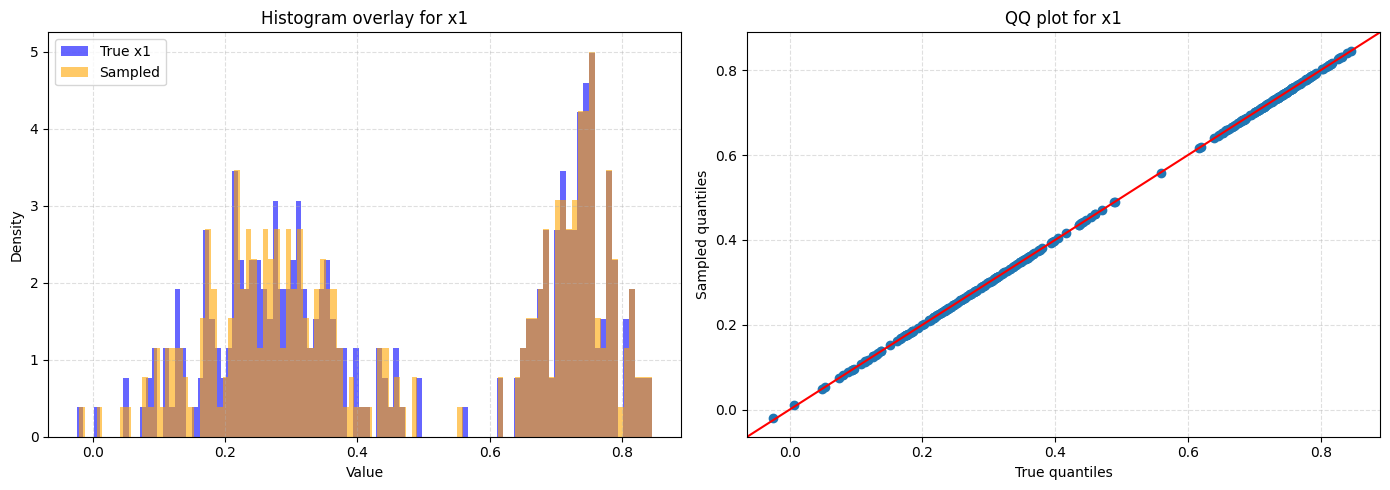

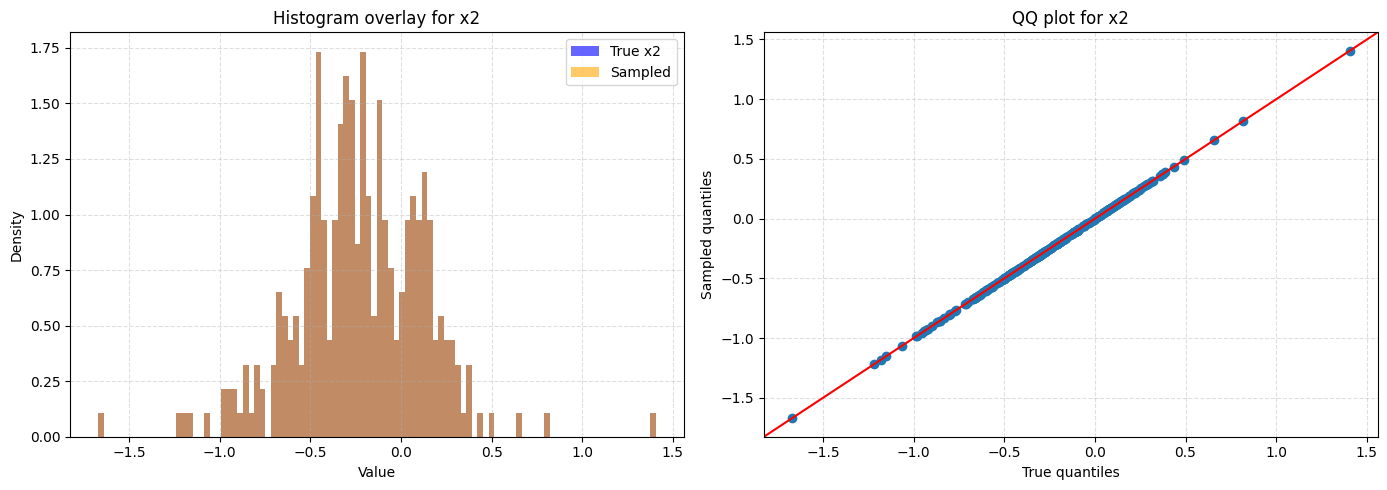

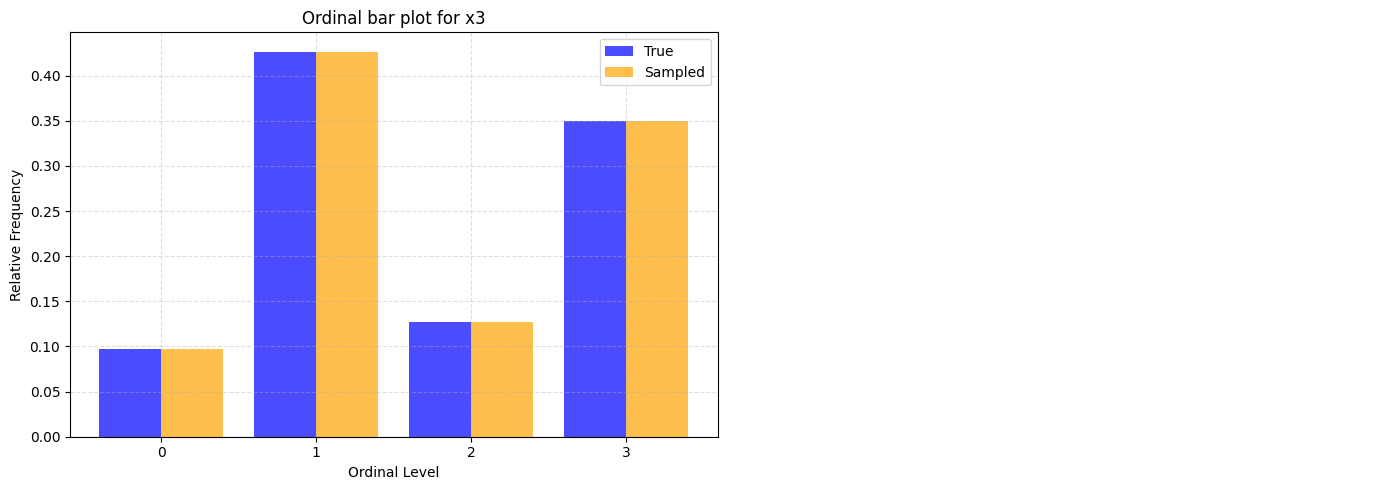

In [30]:
td_model.plot_samples_vs_true(subset,rsamples)


[INFO] Starting full DAG sampling with 10000 samples per node.
[INFO] Using predefined latents samples from dataframe -> therefore n_samples is set to the number of rows in the dataframe: 300
[INFO] Deleting all previously sampled data.
Deleted directory: /home/bule/TramDag/dev_experiment_logs/plot_ordinal_trafo_fkt/x1/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/plot_ordinal_trafo_fkt/x2/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/plot_ordinal_trafo_fkt/x3/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node x1 from dataframe column: x1_U


[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 649.74it/s]

[INFO] Completed sampling for node 'x1'

----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node x2 from dataframe column: x2_U



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 655.12it/s]

[INFO] Completed sampling for node 'x2'

----*----------*-------------*--------Sample Node: x3 ------------*-----------------*-------------------*--
[INFO] Detected 'x3_U_lower' and 'x3_U_upper' — switching to counterfactual logistic sampling mode.


[INFO] Completed sampling for node 'x3'
[INFO] DAG sampling completed successfully for all nodes.


In [ ]:
# samples, latents = td_model.sample(do_interventions={'x1':-3.0})
# inter_df=dgp(n_obs=10_000, doX=[-3,None , None])
# td_model.plot_samples_vs_true(inter_df,samples)

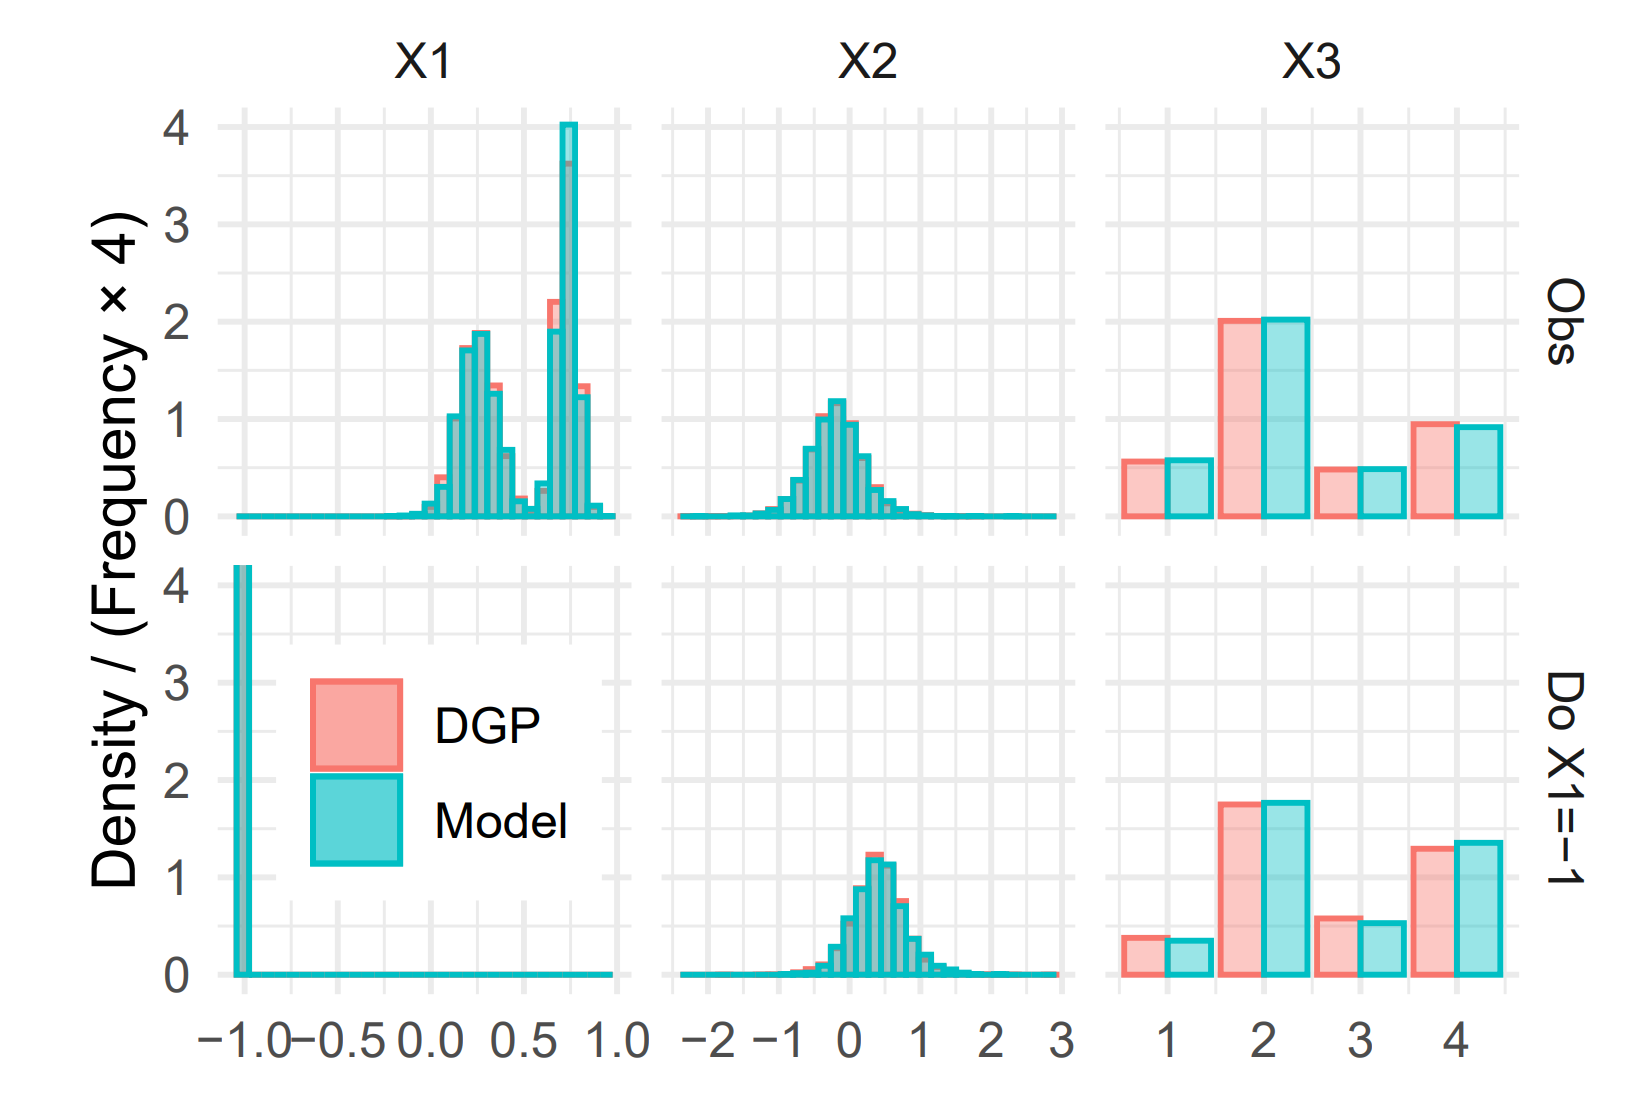

In [ ]:

# verbose = False
# batch_size = 4112

# x = torch.linspace(-1, 1, steps=1000).unsqueeze(1).to(device)  # (100, 1)


# def f(x):
#     return 0.75*np.arctan(5*(x+0.12))  
# for node in node_list:
#     print(f'\n----*----------*-------------*--------check CS of {node} ------------*-----------------*-------------------*--')

#     if node_list[node]['node_type'] == 'source':
#         print("Node type : source, not supported yet.")
#         continue

#     # Load model
#     NODE_DIR = os.path.join(EXPERIMENT_DIR, node)
#     model_path = os.path.join(NODE_DIR, "best_model.pt")

#     tram_model= get_fully_specified_tram_model(node, configuration_dict, debug=True, set_initial_weights=False)
#     tram_model.load_state_dict(torch.load(model_path, map_location=device))
#     tram_model.to(device)   # <--- Move model to device
#     tram_model.eval()
    
#     for i, module in enumerate(tram_model.nn_shift):
#         module_name = module.__class__.__name__
#         if module_name == 'LinearShift':
#             print(f"Module {i} ({module_name}) weights:")
#             print(module.fc.weight.data)
#         else:
#             print(f"Module {i} ({module_name}) predictions:")
#             with torch.no_grad():
#                 y = module(x)
# plt.scatter(x.cpu().numpy(),y.cpu().numpy())
# plt.scatter(x.cpu().numpy(),-f(x.cpu().numpy()),cmap="red")
# plt.show()

In [ ]:
    # def linear_shifts_from_model(self,state='best'):
    #     nodes_list = list(self.models.keys())
        
    #     linear_shift_dict={}
    #     for node in nodes_list:
    #         EXPERIMENT_DIR = self.cfg.conf_dict["PATHS"]["EXPERIMENT_DIR"]
    #         NODE_DIR = os.path.join(EXPERIMENT_DIR, f"{node}")
    #         BEST_MODEL_PATH, LAST_MODEL_PATH, _, _ = model_train_val_paths(NODE_DIR)
            
    #         if state=='best':
    #             LOAD_PATH=BEST_MODEL_PATH
    #         elif state=='last':
    #             LOAD_PATH=LAST_MODEL_PATH
                
    #         if not  os.path.exists(LOAD_PATH):
    #             LOAD_PATH = os.path.join(NODE_DIR, 'initial_model.pt')
    #             print(f"[WARNING] Model file not found for node {node} at {LOAD_PATH}. Using initial model instead.")
            
            
    #         state_dict = torch.load(LOAD_PATH, map_location=self.device)
    #         tram_model=self.models[node]
    #         tram_model.load_state_dict(state_dict)


    #         if  hasattr(tram_model, "nn_shift") and tram_model.nn_shift is not None:
    #             epoch_weights = {}
    #             for i, shift_layer in enumerate(tram_model.nn_shift):
    #                 module_name = shift_layer.__class__.__name__
    #                 if hasattr(shift_layer, "fc") and hasattr(shift_layer.fc, "weight") and module_name == 'LinearShift': :
                        
    #                     epoch_weights[f"shift_{i}"] = shift_layer.fc.weight.detach().cpu().tolist()
    #                 else:
    #                     if self.debug:
    #                         print(f"[DEBUG] shift_{i}: 'fc' or 'weight' or LinearShift not found.")
                            
    #             linear_shift_dict[node]=epoch_weights
    #     return linear_shift_dict

In [ ]:
def standart_logistic_truncated(u_lower, u_upper, size):
    # sample n in standard logistic and truncate to [u_lower, u_upper] resample if out of bounds:
    samples = []
    while len(samples) < size:
        u = logistic.rvs(size=size - len(samples))
        u_trunc = u[(u >= u_lower) & (u <= u_upper)]
        samples.extend(u_trunc)
    return np.array(samples[:size])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import logistic

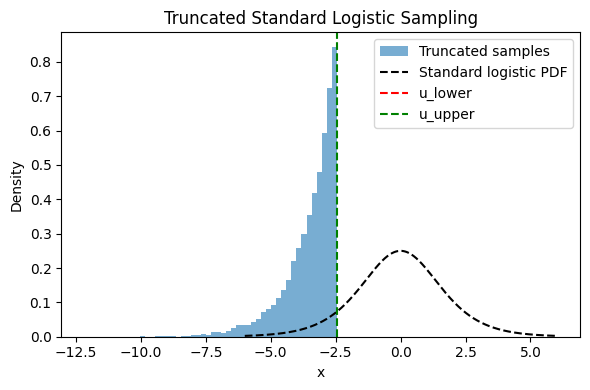

In [ ]:
def standart_logistic_truncated(u_lower, u_upper, size):
    samples = []
    while len(samples) < size:
        u = logistic.rvs(size=size - len(samples))
        u_trunc = u[(u >= u_lower) & (u <= u_upper)]
        samples.extend(u_trunc)
    return np.array(samples[:size])

# example values
u_lower = u_df.iloc[0]["x3_U_lower"]
u_upper = u_df.iloc[0]["x3_U_upper"]
latents_from_range = standart_logistic_truncated(u_lower, u_upper, 10000)

# histogram and logistic pdf
x = np.linspace(-6, 6, 1000)
plt.figure(figsize=(6, 4))
plt.hist(latents_from_range, bins=50, density=True, alpha=0.6, label="Truncated samples")
plt.plot(x, logistic.pdf(x), "k--", label="Standard logistic PDF")
plt.axvline(u_lower, color="r", linestyle="--", label="u_lower")
plt.axvline(u_upper, color="g", linestyle="--", label="u_upper")
plt.legend()
plt.xlabel("x")
plt.ylabel("Density")
plt.title("Truncated Standard Logistic Sampling")
plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import logistic, probplot

In [ ]:
u_lower=u_df.iloc[0][f"x3_U_lower"]
u_upper=u_df.iloc[0][f"x3_U_upper"]
latents_from_range=standart_logistic_truncated(u_lower, u_upper, 1)
latents_from_range

array([-5.03987064])

In [ ]:
def sample_full_dag_v2(configuration_dict,
                    EXPERIMENT_DIR,
                    device,
                    do_interventions={},
                    predefined_latent_samples_df: pd.DataFrame = None,
                    number_of_samples: int = 10_000,
                    batch_size: int = 256,
                    delete_all_previously_sampled: bool = True,
                    verbose: bool = True,
                    debug: bool = False,
                    minmax_dict=None,
                    use_initial_weights_for_sampling: bool = False):
    """
    Sample values for all nodes in a DAG given trained TRAM models, respecting
    parental ordering. Supports both generative sampling (new U's) and
    reconstruction sampling (predefined U's), as well as node-level interventions.

    Parameters
    ----------
    configuration_dict : dict
        Full experiment configuration. Must contain a "nodes" entry where each node
        has metadata including:
            - 'node_type': str, either 'source' or other
            - 'parents': list of parent node names
            - 'min': float, minimum allowed value for the node
            - 'max': float, maximum allowed value for the node
            - 'data_type': str, e.g. "continuous" or "ordinal"
    EXPERIMENT_DIR : str
        Base directory where per-node models and sampling results are stored.
    device : torch.device
        Device for model evaluation (e.g., 'cuda' or 'cpu').
    do_interventions : dict, optional
        Mapping of node names to fixed values. For intervened nodes, the model is
        bypassed and all samples are set to the specified value. Example:
        {'x1': 1.0}.
    predefined_latent_samples_df : pd.DataFrame, optional
        DataFrame of predefined latent variables (U's) for reconstruction. Must
        contain one column per node in the form "{node}_U". If provided, the number
        of samples is set to the number of rows in this DataFrame.
    number_of_samples : int, default=10_000
        Number of samples to draw per node when no predefined latent samples are given.
    batch_size : int, default=32
        Batch size for DataLoader evaluation during sampling.
    delete_all_previously_sampled : bool, default=True
        If True, deletes all existing sampled.pt/latents.pt files before starting.
    verbose : bool, default=True
        If True, print progress information.
    debug : bool, default=False
        If True, print detailed debug information for troubleshooting.

    Returns
    -------
    sampled_by_node : dict
        Mapping from node name to a tensor of sampled values (on CPU).
    latents_by_node : dict
        Mapping from node name to the latent variables (U's) used to generate
        those samples (on CPU).

    Notes
    -----
    - The function respects DAG ordering by ensuring parents are sampled before
      their children.
    - In generative mode (no predefined_latent_samples_df), latent U's are sampled
      from a standard logistic distribution and parents are taken from sampled.pt.
    - In reconstruction mode (with predefined_latent_samples_df), latent U's are
      read from the DataFrame, but parent values are still loaded from sampled.pt
      unless explicitly overridden upstream.
    - Models are loaded from "best_model.pt" in each node's directory and applied
      in eval mode with no gradient tracking.
    - Continuous outcomes are sampled via vectorized root finding
      (Chandrupatla's algorithm), while ordinal outcomes use categorical sampling.
    """
    if verbose or debug:
        print(f"[INFO] Starting full DAG sampling with {number_of_samples} samples per node.")
        if do_interventions:
            print(f"[INFO] Interventions specified for nodes: {list(do_interventions.keys())}")
            
    if debug:
        print('[DEBUG] sample_full_dag: device:', device)
        
        
    if predefined_latent_samples_df is not None:
        number_of_samples = len(predefined_latent_samples_df)
        if verbose or debug:
            print(f'[INFO] Using predefined latents samples from dataframe -> therefore n_samples is set to the number of rows in the dataframe: {len(predefined_latent_samples_df)}')
    
    
    
    target_nodes_dict=configuration_dict["nodes"]

    # Collect results for direct use in notebooks
    sampled_by_node = {}
    latents_by_node = {}


    if delete_all_previously_sampled:
        if verbose or debug:
            print("[INFO] Deleting all previously sampled data.")
        delete_all_samplings(target_nodes_dict, EXPERIMENT_DIR)
    
    
    #### FOLLOWING ALONG THE CAUSAL ORDERING OF THE SPECIFICATION IN THE TARGET_NODES_DICT:
    for node in target_nodes_dict: # for each node in the target_nodes_dict
                    
        print(f'\n----*----------*-------------*--------Sample Node: {node} ------------*-----------------*-------------------*--') 
        
        ## 1. Paths collect samplings for each node in a subdirectory
        NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
        SAMPLING_DIR = os.path.join(NODE_DIR, 'sampling')
        os.makedirs(SAMPLING_DIR, exist_ok=True)
        SAMPLED_PATH = os.path.join(SAMPLING_DIR, "sampled.pt")
        LATENTS_PATH = os.path.join(SAMPLING_DIR, "latents.pt")
        
        ## 2. Check if the parents are already sampled -> must be given due to the causal ordering
        for parent in target_nodes_dict[node]['parents']:
            parent_dir = os.path.join(EXPERIMENT_DIR, parent)
            try:
                check_sampled_and_latents(parent_dir, debug=debug)
            except FileNotFoundError:
                if verbose or debug:
                    print(f"[INFO] Skipping {node} as parent '{parent}' is not sampled yet.")

        
        ## INTERVENTION, if node is to be intervened on , data is just saved
        if do_interventions and node in do_interventions.keys():
                # For interventions make all the values the same for 
                intervention_value = do_interventions[node]
                if verbose or debug:
                    print(f"[INFO] Applying intervention for node '{node}' with value {intervention_value}")
                intervention_vals = torch.full((number_of_samples,), intervention_value)
                torch.save(intervention_vals, SAMPLED_PATH)
                
                ### dummy latents jsut for the check , not needed
                dummy_latents = torch.full((number_of_samples,), float('nan'))  
                torch.save(dummy_latents, LATENTS_PATH)
                
                # Store for immediate use
                sampled_by_node[node] = intervention_vals
                latents_by_node[node] = dummy_latents
                if verbose or debug:
                    print(f'[INFO] Interventional data for node {node} is saved')
                continue 

        ##### NO INTERVENTION, based on the sampled data from the parents the latents for each node the observational distribution is generated    
        else:#TODO write down all cases for sampling here

            #################################### load model and weigths 
            tram_model=load_tram_model_weights(node,configuration_dict, NODE_DIR,debug=False,verbose=False, device='cpu',  use_initial_weights_for_sampling=False)
            
            
            #### latens and laten intervals
            has_interval_latents = (
                predefined_latent_samples_df is not None
                and f"{node}_U_lower" in predefined_latent_samples_df.columns
                and f"{node}_U_upper" in predefined_latent_samples_df.columns
            )

            if (
                predefined_latent_samples_df is not None
                and f"{node}_U" in predefined_latent_samples_df.columns
                and not has_interval_latents
            ):
                predefinded_sample_name = f"{node}_U"
                predefinded_sample = predefined_latent_samples_df[predefinded_sample_name].values
                if verbose or debug:
                    print(f"[INFO] Using predefined latents samples for node {node} from dataframe column: {predefinded_sample_name}")
                latent_sample = torch.tensor(predefinded_sample, dtype=torch.float32).to(device)

            else:
                if verbose or debug:
                    if has_interval_latents:
                        print(f"[INFO] Detected '{node}_U_lower' and '{node}_U_upper' — switching to counterfactual logistic sampling mode. NOT IMPLEMENTED YET. defaulting to jsut logistic sampling")
                        latent_sample = torch.tensor(logistic.rvs(size=number_of_samples), dtype=torch.float32).to(device)
                    else:
                        print(f"[INFO] Sampling new latents for node {node} from standard logistic distribution")
                        
                        latent_sample = torch.tensor(logistic.rvs(size=number_of_samples), dtype=torch.float32).to(device)
            
            
            ###################################################### Counterfactual logic #########################################
            
            # NO Probablistic parents samplings
            if not has_proba_parents(target_nodes_dict,node,debug=debug):
                if not has_interval_latents:
                    sampled=det_parents_det_node_sampling(node,target_nodes_dict,number_of_samples,batch_size,tram_model,latent_sample,debug,minmax_dict)
                if has_interval_latents:
                    sampled=det_parents_proba_node_sampling(node,target_nodes_dict,number_of_samples,batch_size,tram_model,predefined_latent_samples_df,debug)
            
            # Probabalistic paretns sampling 
            if has_proba_parents(target_nodes_dict,node,debug=debug):
                if has_interval_latents:
                    sampled=proba_parents_proba_node_sampling(node,target_nodes_dict,number_of_samples,batch_size,tram_model,predefined_latent_samples_df,debug)  
                if not has_interval_latents:
                    sampled=proba_parents_det_node_sampling(node,target_nodes_dict,number_of_samples,batch_size,tram_model,predefined_latent_samples_df,latent_sample,debug,minmax_dict)
                    
                
            ###*************************************************** Saving the latenst and sampled  ************************************************
            if torch.isnan(sampled).any():
                print(f"[WARNING] NaNs detected in sampled output for node '{node}'")
                
            torch.save(sampled, SAMPLED_PATH)
            torch.save(latent_sample, LATENTS_PATH)
            
            # Store CPU copies for immediate use
            sampled_by_node[node] = sampled.detach().cpu()
            latents_by_node[node] = latent_sample.detach().cpu()
            
            if verbose or debug:
                print(f"[INFO] Completed sampling for node '{node}'")
            
        
    if verbose or debug:
        print("[INFO] DAG sampling completed successfully for all nodes.")

    return sampled_by_node, latents_by_node


def det_parents_det_node_sampling(node,target_nodes_dict,number_of_samples,batch_size,tram_model,latent_sample,debug,minmax_dict):
    
        # create dataframe from sampled parents + dummy if no parents 
        sampled_df=create_df_from_sampled(node, target_nodes_dict, number_of_samples, EXPERIMENT_DIR)
        
        sample_dataset = GenericDataset(sampled_df,target_col=node,
                                            target_nodes=target_nodes_dict,
                                            return_intercept_shift=True,
                                            return_y=False,
                                            debug=debug)
        
        sample_loader = DataLoader(sample_dataset, batch_size=batch_size, shuffle=False,num_workers=4, pin_memory=True)
        
        ###*************************************************** Continous Modelled Outcome ************************************************
        
        if is_outcome_modelled_continous(node,target_nodes_dict):
            sampled=sample_continous_modelled_target(node,target_nodes_dict,sample_loader,tram_model,latent_sample=latent_sample,device=device, debug=debug,minmax_dict=minmax_dict)
            
        ###*************************************************** Ordinal Modelled Outcome ************************************************
        
        elif is_outcome_modelled_ordinal(node,target_nodes_dict):
            sampled=sample_ordinal_modelled_target(sample_loader,tram_model,latent_sample=latent_sample,device=device, debug=debug)
        
        else:
            raise ValueError(f"Unsupported data_type '{target_nodes_dict[node]['data_type']}' for node '{node}' in sampling.")
        return sampled

def det_parents_proba_node_sampling(node,target_nodes_dict,number_of_samples,batch_size,tram_model,predefined_latent_samples_df,debug):
    
    sample_df=create_df_from_sampled(node, target_nodes_dict, number_of_samples, EXPERIMENT_DIR)
    counterfactual_frequency=[]
    for i ,_ in enumerate(predefined_latent_samples_df[f"{node}"]):
        ### Sampling from truncated logistic
        u_lower=predefined_latent_samples_df[f"{node}_U_lower"][i]
        u_upper=predefined_latent_samples_df[f"{node}_U_upper"][i]
        latents_from_range=standart_logistic_truncated(u_lower, u_upper, number_of_samples)
        # save the sampled latens to csv
        RANGED_LATENT_PATH=os.path.join(EXPERIMENT_DIR,node ,"sampling","counterfactual",f'latents_range_obs_{i}.csv')
        # save to csv
        np.savetxt(RANGED_LATENT_PATH, latents_from_range, delimiter=",")
        if debug:
            print(f"[DEBUG] Saved latent vector ({len(latents_from_range)} samples) to {RANGED_LATENT_PATH}")
        
        # repeat the i-th row number_of_samples times
        df_rep_i=sample_df.iloc[[i]].repeat(number_of_samples).reset_index(drop=True)
        sample_dataset = GenericDataset(df_rep_i,target_col=node,
                                            target_nodes=target_nodes_dict,
                                            return_intercept_shift=True,
                                            return_y=False,
                                            debug=debug)
        sample_loader = DataLoader(sample_dataset, batch_size=batch_size, shuffle=False,num_workers=4, pin_memory=True)  
        
        
        
        if is_outcome_modelled_ordinal(node,target_nodes_dict):
            range_sampled=sample_ordinal_modelled_target(sample_loader,tram_model,latent_sample=torch.tensor(latents_from_range, dtype=torch.float32).to(device),device=device, debug=debug)
        
        RANGED_SAMPLED_PATH=os.path.join(EXPERIMENT_DIR,node ,"sampling","counterfactual",f'latents_sampled_obs_{i}.csv')
        
        np.savetxt(RANGED_SAMPLED_PATH, np.array(range_sampled).squeeze(), delimiter=",")
        if debug:
            print(f"[DEBUG] Saved latent vector ({len(latents_from_range)} samples) to {RANGED_SAMPLED_PATH}")
            
        # frequency count of how many times each category was sampled as proba distributin e.g. 3 classes: [0.1,0.3,0.6]     
        counts = np.bincount(range_sampled.numpy())
        frequencies = counts / len(range_sampled)
        counterfactual_frequency.append(frequencies)
    return counterfactual_frequency


def proba_parents_proba_node_sampling(node,target_nodes_dict,number_of_samples,batch_size,tram_model,predefined_latent_samples_df,debug):
    sample_df=create_df_from_sampled(node, target_nodes_dict, number_of_samples, EXPERIMENT_DIR)
    counterfactual_frequency=[]
    parents=target_nodes_dict[node]['parents']
    counterfactual_frequency=[]
    for i ,_ in enumerate(predefined_latent_samples_df[f"{node}"]):
                u_lower=predefined_latent_samples_df[f"{node}_U_lower"][i]
                u_upper=predefined_latent_samples_df[f"{node}_U_upper"][i]
                latents_from_range=standart_logistic_truncated(u_lower, u_upper, number_of_samples)
                RANGED_LATENT_PATH=os.path.join(EXPERIMENT_DIR,node ,"sampling","counterfactual",f'latents_range_obs_{i}.csv')
                # save to csv
                np.savetxt(RANGED_LATENT_PATH, latents_from_range, delimiter=",")
                if debug:
                    print(f"[DEBUG] Saved latent vector ({len(latents_from_range)} samples) to {RANGED_LATENT_PATH}")
                df_rep_i=load_parents_with_range(sample_df, i, parents, number_of_samples, EXPERIMENT_DIR, debug=False)

                sample_dataset = GenericDataset(df_rep_i,target_col=node,
                                                    target_nodes=target_nodes_dict,
                                                    return_intercept_shift=True,
                                                    return_y=False,
                                                    debug=debug)
                sample_loader = DataLoader(sample_dataset, batch_size=batch_size, shuffle=False,num_workers=4, pin_memory=True)  
                
                
                
                if is_outcome_modelled_ordinal(node,target_nodes_dict):
                    range_sampled=sample_ordinal_modelled_target(sample_loader,tram_model,latent_sample=torch.tensor(latents_from_range, dtype=torch.float32).to(device),device=device, debug=debug)
                
                RANGED_SAMPLED_PATH=os.path.join(EXPERIMENT_DIR,node ,"sampling","counterfactual",f'latents_sampled_obs_{i}.csv')
                
                np.savetxt(RANGED_SAMPLED_PATH, np.array(range_sampled).squeeze(), delimiter=",")
                if debug:
                    print(f"[DEBUG] Saved latent vector ({len(latents_from_range)} samples) to {RANGED_SAMPLED_PATH}")
                    
                # frequency count of how many times each category was sampled as proba distributin e.g. 3 classes: [0.1,0.3,0.6]     
                counts = np.bincount(range_sampled.numpy())
                frequencies = counts / len(range_sampled)
                counterfactual_frequency.append(frequencies)
    return counterfactual_frequency



def proba_parents_det_node_sampling(node,target_nodes_dict,number_of_samples,batch_size,tram_model,predefined_latent_samples_df,latent_sample,debug,minmax_dict):
    
    sample_df=create_df_from_sampled(node, target_nodes_dict, number_of_samples, EXPERIMENT_DIR)
    counterfactual_frequency=[]
    parents=target_nodes_dict[node]['parents']
    counterfactual_frequency=[]
    for i ,_ in enumerate(predefined_latent_samples_df[f"{node}"]):

                df_rep_i=load_parents_with_range(sample_df, i, parents, number_of_samples, EXPERIMENT_DIR, debug=False)

                sample_dataset = GenericDataset(df_rep_i,target_col=node,
                                                    target_nodes=target_nodes_dict,
                                                    return_intercept_shift=True,
                                                    return_y=False,
                                                    debug=debug)
                sample_loader = DataLoader(sample_dataset, batch_size=batch_size, shuffle=False,num_workers=4, pin_memory=True)  
                
                
                if is_outcome_modelled_continous(node,target_nodes_dict):
                    range_sampled=sample_continous_modelled_target(node,target_nodes_dict,sample_loader,tram_model,latent_sample=latent_sample,device=device, debug=debug,minmax_dict=minmax_dict)
                     
                if is_outcome_modelled_ordinal(node,target_nodes_dict):
                    range_sampled=sample_ordinal_modelled_target(sample_loader,tram_model,latent_sample=latents,device=device, debug=debug)
                
                RANGED_SAMPLED_PATH=os.path.join(EXPERIMENT_DIR,node ,"sampling","counterfactual",f'latents_sampled_obs_{i}.csv')
                
                np.savetxt(RANGED_SAMPLED_PATH, np.array(range_sampled).squeeze(), delimiter=",")
                if debug:
                    print(f"[DEBUG] Saved latent vector ({len(latents_from_range)} samples) to {RANGED_SAMPLED_PATH}")
                    
                # frequency count of how many times each category was sampled as proba distributin e.g. 3 classes: [0.1,0.3,0.6]     
                counts = np.bincount(range_sampled.numpy())
                frequencies = counts / len(range_sampled)
                counterfactual_frequency.append(frequencies)
    return counterfactual_frequency


def has_proba_parents(target_nodes_dict,node,debug=False):
        for parent in target_nodes_dict[node]['parents']:
            path = os.path.join(EXPERIMENT_DIR, parent, "sampling", "sampled.pt")
            if os.path.exists(path):
                try:
                    sampled=torch.load(path, map_location="cpu")
                    if sampled.ndim > 1 and sampled.shape[1] > 1:
                        if debug:
                            print(f"[DEBUG] has_proba_parents:  '{parent}' (shape {tuple(sampled.shape)}) - looks like probabilities")
                        return True
                    else:
                        continue
                except FileNotFoundError:
                    if debug:
                        print(f"[DEBUG] has_proba_parents: Skipping {node} as parent '{parent}' is not sampled yet.")
        return False


def load_parents_with_range(df_sampled, i, parents, number_of_samples, EXPERIMENT_DIR, debug=False):
    # Check index validity
    if i < 0 or i >= len(df_sampled):
        raise IndexError(f"Index {i} out of bounds for df_sampled with {len(df_sampled)} rows.")
    
    # Create repeated DataFrame
    df_range = pd.DataFrame(
        np.tile(df_sampled.iloc[i].values, (number_of_samples, 1)),
        columns=df_sampled.columns
    )

    # For missing parent variables, load sampled ranges from files
    for parent in parents:
        if parent not in df_range.columns:
            path = os.path.join(EXPERIMENT_DIR, parent, "sampling", f"range_samples_{i}_.csv")
            
            if not os.path.exists(path):
                raise FileNotFoundError(f"Missing file: {path}")
            
            df_parent = pd.read_csv(path)
            
            if len(df_parent) != number_of_samples:
                raise ValueError(
                    f"File {path} has {len(df_parent)} samples, expected {number_of_samples}."
                )
            
            if df_parent.shape[1] != 1:
                raise ValueError(
                    f"File {path} has {df_parent.shape[1]} columns, expected exactly 1."
                )
            
            df_range[parent] = df_parent.iloc[:, 0].values
    
    if debug:
        print(f"[DEBUG] Loaded row {i} -> {len(df_range)} samples")
        print(f"[DEBUG] Columns: {list(df_range.columns)}")

    return df_range
    pass


def standart_logistic_truncated(u_lower, u_upper, size):
    # sample n in standard logistic and truncate to [u_lower, u_upper] resample if out of bounds:
    samples = []
    while len(samples) < size:
        u = logistic.rvs(size=size - len(samples))
        u_trunc = u[(u >= u_lower) & (u <= u_upper)]
        samples.extend(u_trunc)
    return np.array(samples[:size])


def load_tram_model_weights(node,configuration_dict, NODE_DIR,debug=False,verbose=False, device='cpu',  use_initial_weights_for_sampling=False):

            tram_model = get_fully_specified_tram_model(
                node, configuration_dict, debug=debug, device=device, verbose=verbose
            ).to(device)

            BEST_MODEL_PATH = os.path.join(NODE_DIR, "best_model.pt")
            INIT_MODEL_PATH = os.path.join(NODE_DIR, "initial_model.pt")

            try:
                if use_initial_weights_for_sampling:
                    if verbose or debug:
                        print(f"[INFO] Using initial weights for sampling for node '{node}'")
                    if not os.path.exists(INIT_MODEL_PATH):
                        raise FileNotFoundError(f"Initial model not found at {INIT_MODEL_PATH}")
                    tram_model.load_state_dict(torch.load(INIT_MODEL_PATH, map_location=device))

                else:
                    if os.path.exists(BEST_MODEL_PATH):
                        tram_model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
                        if verbose or debug:
                            print(f"[INFO] Loaded best model weights for node '{node}' from {BEST_MODEL_PATH}")
                    elif os.path.exists(INIT_MODEL_PATH):
                        tram_model.load_state_dict(torch.load(INIT_MODEL_PATH, map_location=device))
                        print(f"[WARNING] Best model not found for node '{node}'. Using initial weights instead.")
                    else:
                        raise FileNotFoundError(
                            f"No model weights found for node '{node}'. "
                            f"Expected one of: {BEST_MODEL_PATH} or {INIT_MODEL_PATH}"
                        )

            except Exception as e:
                print(f"[ERROR] Failed to load model weights for node '{node}': {e}")
                raise
            return tram_model

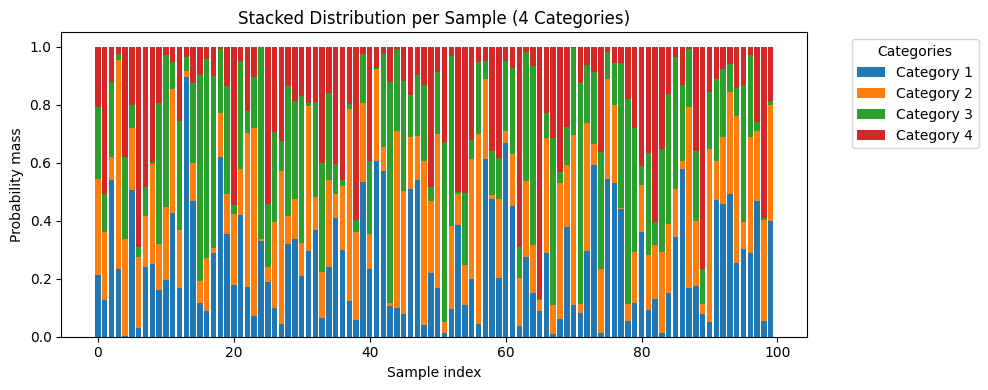

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate 100 samples, each a probability distribution over 4 categories
np.random.seed(0)
data = np.random.dirichlet(np.ones(4), size=100)  # shape (100, 4)

# Plot stacked bars
fig, ax = plt.subplots(figsize=(10, 4))
bottom = np.zeros(len(data))

for i in range(4):
    ax.bar(range(len(data)), data[:, i], bottom=bottom, label=f"Category {i+1}")
    bottom += data[:, i]

plt.legend(title="Categories", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Sample index")
plt.ylabel("Probability mass")
plt.title("Stacked Distribution per Sample (4 Categories)")
plt.tight_layout()
plt.show()
